In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import f1_score, confusion_matrix
from sklearn.model_selection import train_test_split, ParameterGrid

!pip install catboost
from catboost import CatBoostClassifier

In [2]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


# Load data

In [3]:
DIR  = "/gdrive/MyDrive/Data_Science_Projekte/earth_quake_damage_dd/"

train_values = pd.read_csv(DIR+'data/train_values.csv', index_col='building_id')
train_labels = pd.read_csv(DIR+'data/train_labels.csv', index_col='building_id')
test_values  = pd.read_csv(DIR+"data/test_values.csv", index_col='building_id')
submission_format = pd.read_csv(DIR+"data/submission_format.csv", index_col='building_id')

train_data = train_values.join(train_labels)
train_data.head(5)

,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,...,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,damage_grade
building_id,,,,,,,,,,,,,,,,,,,,,
802906,6,487,12198,2,30,6,5,t,r,n,...,0,0,0,0,0,0,0,0,0,3
28830,8,900,2812,2,10,8,7,o,r,n,...,0,0,0,0,0,0,0,0,0,2
94947,21,363,8973,2,10,5,5,t,r,n,...,0,0,0,0,0,0,0,0,0,3
590882,22,418,10694,2,10,6,5,t,r,n,...,0,0,0,0,0,0,0,0,0,2
201944,11,131,1488,3,30,8,9,t,r,n,...,0,0,0,0,0,0,0,0,0,3


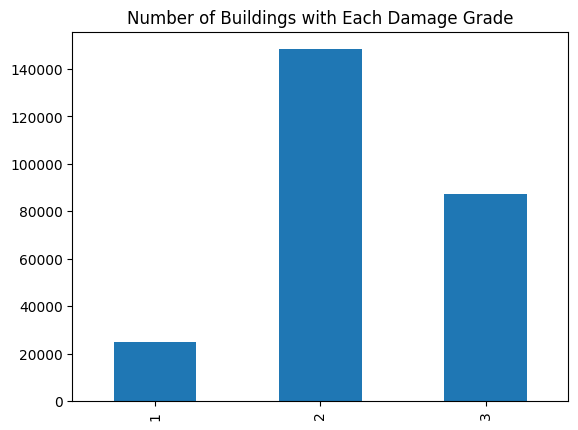

In [4]:
(train_labels.damage_grade.value_counts().sort_index()
    .plot.bar(title="Number of Buildings with Each Damage Grade"))
plt.show()

In [5]:
train_values.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 260601 entries, 802906 to 747594
Data columns (total 38 columns):
 #   Column                                  Non-Null Count   Dtype 
---  ------                                  --------------   ----- 
 0   geo_level_1_id                          260601 non-null  int64 
 1   geo_level_2_id                          260601 non-null  int64 
 2   geo_level_3_id                          260601 non-null  int64 
 3   count_floors_pre_eq                     260601 non-null  int64 
 4   age                                     260601 non-null  int64 
 5   area_percentage                         260601 non-null  int64 
 6   height_percentage                       260601 non-null  int64 
 7   land_surface_condition                  260601 non-null  object
 8   foundation_type                         260601 non-null  object
 9   roof_type                               260601 non-null  object
 10  ground_floor_type                       260601 non-

# Location probability encoding

Encoding the location by the probability of each damage grade. We consider geo_level_3 (the smallest region) if it has enough data otherwise geo_level_2 respectively geo_level_1.

In [6]:
def get_prob_encoding_dict(train_data, min_data=100):
  #count how often region is in data
  geo_level_1_count = train_data.geo_level_1_id.value_counts()
  geo_level_2_count = train_data.geo_level_2_id.value_counts()
  geo_level_3_count = train_data.geo_level_3_id.value_counts()

  #level has enough data
  dict_geo_level_1_valid = (geo_level_1_count > 100).to_dict()
  dict_geo_level_2_valid = (geo_level_2_count > 100).to_dict()
  dict_geo_level_3_valid = (geo_level_3_count > 100).to_dict()

  mask_geo_level_1_valid = train_data.geo_level_1_id.map(dict_geo_level_1_valid)
  mask_geo_level_2_valid = train_data.geo_level_2_id.map(dict_geo_level_2_valid)
  mask_geo_level_3_valid = train_data.geo_level_3_id.map(dict_geo_level_3_valid)

  #get dictionaries
  prob_damage_grade = (train_labels.damage_grade.value_counts() / train_labels.size).to_dict()
  prob_damage_grade_geo_level_1 = (train_data
                                   .loc[mask_geo_level_1_valid]
                                   .loc[:,['geo_level_1_id', 'damage_grade']]
                                   .groupby(['geo_level_1_id', 'damage_grade'])
                                   .size()
                                   .div(geo_level_1_count, axis=0, level='geo_level_1_id')
                                   .unstack(fill_value=0)
                                   .to_dict()
  )

  prob_damage_grade_geo_level_2 = (train_data
                                   .loc[mask_geo_level_2_valid]
                                   .loc[:,['geo_level_2_id', 'damage_grade']]
                                   .groupby(['geo_level_2_id', 'damage_grade'])
                                   .size()
                                   .div(geo_level_2_count, axis=0, level='geo_level_2_id')
                                   .unstack(fill_value=0)
                                   .to_dict()
  )
  prob_damage_grade_geo_level_3 = (train_data
                                   .loc[mask_geo_level_3_valid]
                                   .loc[:,['geo_level_3_id', 'damage_grade']]
                                   .groupby(['geo_level_3_id', 'damage_grade'])
                                   .size()
                                   .div(geo_level_3_count, axis=0, level='geo_level_3_id')
                                   .unstack(fill_value=0)
                                   .to_dict()
  )
  return [prob_damage_grade, prob_damage_grade_geo_level_1, prob_damage_grade_geo_level_2, prob_damage_grade_geo_level_3]

In [7]:
def add_geo_prob_damage_grade(X, list_dict_geo_lvl):
  for i in [1,2,3]:
    X.loc[:, 'geo_prob_' + str(i)] = list_dict_geo_lvl[0] [i]
    values_level_1 = X.loc[:,'geo_level_1_id'].map(list_dict_geo_lvl[1][i])
    X.loc[values_level_1.notna(),'geo_prob_' + str(i)] = values_level_1.loc[values_level_1.notna()]
    values_level_2 = X.loc[:,'geo_level_2_id'].map(list_dict_geo_lvl[2][i])
    X.loc[values_level_2.notna(),'geo_prob_' + str(i)] = values_level_2.loc[values_level_2.notna()]
    values_level_3 = X.loc[:,'geo_level_3_id'].map(list_dict_geo_lvl[3][i])
    X.loc[values_level_3.notna(),'geo_prob_' + str(i)] = values_level_3.loc[values_level_3.notna()]
  return X

# Search for best hyperparameters

In [8]:
cat_cols=['geo_level_1_id','geo_level_2_id','geo_level_3_id','land_surface_condition', 'foundation_type', 'roof_type',
       'ground_floor_type', 'other_floor_type', 'position',
       'plan_configuration', 'legal_ownership_status','count_floors_pre_eq', 'has_superstructure_adobe_mud',
       'has_superstructure_mud_mortar_stone', 'has_superstructure_stone_flag',
       'has_superstructure_cement_mortar_stone',
       'has_superstructure_mud_mortar_brick',
       'has_superstructure_cement_mortar_brick', 'has_superstructure_timber',
       'has_superstructure_bamboo', 'has_superstructure_rc_non_engineered',
       'has_superstructure_rc_engineered', 'has_superstructure_other',
       'legal_ownership_status', 'has_secondary_use',
       'has_secondary_use_agriculture', 'has_secondary_use_hotel',
       'has_secondary_use_rental', 'has_secondary_use_institution',
       'has_secondary_use_school', 'has_secondary_use_industry',
       'has_secondary_use_health_post', 'has_secondary_use_gov_office',
       'has_secondary_use_use_police', 'has_secondary_use_other']

In [9]:
param_grid = {'iterations': [50],
              'depth': [6, 8],
}
param_list = list(ParameterGrid(param_grid))

In [10]:
X_train, X_val, y_train, y_val = train_test_split(train_values, train_labels, test_size=0.20)

list_dict_geo_lvl = get_prob_encoding_dict(X_train.join(y_train))
X_train = add_geo_prob_damage_grade(X_train, list_dict_geo_lvl)
X_val = add_geo_prob_damage_grade(X_val, list_dict_geo_lvl)

training_scores=[]
val_scores=[]
best_score=0

for params in param_list:
  model = CatBoostClassifier(
      random_seed=42,
      eval_metric='TotalF1',
      cat_features=cat_cols,
      verbose=50,
      **params
  )
  model.fit(
      X_train, y_train,
      eval_set=(X_val, y_val)
  )

  pred_y_train = model.predict(X_train)
  train_score = f1_score(y_train, pred_y_train, average='micro')
  training_scores.append(train_score)
  print('training score: {0: .4f}'.format(train_score))


  pred_y_val = model.predict(X_val)
  val_score = f1_score(y_val, pred_y_val, average='micro')
  val_scores.append(train_score)
  print('validation score: {0: .4f}'.format(val_score))

  if val_score > best_score:
    best_score = val_score
    best_model = model
    best_params = params

Learning rate set to 0.377314
0:	learn: 0.6858646	test: 0.6809068	best: 0.6809068 (0)	total: 1.86s	remaining: 1m 30s
49:	learn: 0.7339181	test: 0.7346845	best: 0.7346845 (49)	total: 57.2s	remaining: 0us

bestTest = 0.7346844649
bestIteration = 49

training score:  0.7547
validation score:  0.7409
Learning rate set to 0.377314
0:	learn: 0.6940080	test: 0.6908340	best: 0.6908340 (0)	total: 1.36s	remaining: 1m 6s
49:	learn: 0.7403006	test: 0.7364809	best: 0.7365890 (48)	total: 1m 1s	remaining: 0us

bestTest = 0.736589038
bestIteration = 48

Shrink model to first 49 iterations.
training score:  0.7585
validation score:  0.7420


# Final training and prediction

In [11]:
list_dict_geo_lvl = get_prob_encoding_dict(train_data)
X_train = add_geo_prob_damage_grade(train_values, list_dict_geo_lvl)
X_test = add_geo_prob_damage_grade(test_values, list_dict_geo_lvl)
y_train = train_labels

model = CatBoostClassifier(
    random_seed=42,
    eval_metric='TotalF1',
    cat_features=cat_cols,
    verbose=50,
    **best_params
)
model.fit(
    X_train, y_train,
)

pred_y_train = model.predict(X_train)
train_score = f1_score(y_train, pred_y_train, average='micro')
print('training score: {0: .4f}'.format(train_score))

Learning rate set to 0.5
0:	learn: 0.6935533	total: 1.43s	remaining: 1m 10s
49:	learn: 0.7425555	total: 1m 14s	remaining: 0us
training score:  0.7583


In [12]:
predictions = model.predict(X_test)

# Save submission

In [13]:
my_submission = pd.DataFrame(data=predictions,
                             columns=submission_format.columns,
                             index=submission_format.index)

In [14]:
my_submission.head()

,damage_grade
building_id,
300051,3
99355,2
890251,2
745817,1
421793,3


In [15]:
my_submission.to_csv(DIR+'submissions/submission_first.csv')